# R5 - Triplet Loss for Image Similarity Assessment

In this notebook, we'll implement a Triplet Network using triplet loss for flower image similarity on the 102 Flowers Dataset.

## Project Overview

Building on our exploration and previous implementations, we'll now:

1. Prepare the dataset with appropriate preprocessing
2. Implement a dynamic triplet generation strategy
3. Create a modular Triplet network architecture with timm backbones
4. Train and evaluate our model on the flower similarity task using triplet loss

The triplet loss helps learn embeddings where images from the same class are closer together, and images from different classes are farther apart.

## Section 1: Environment Setup

First, let's install the necessary packages and import the required libraries.

In [1]:
# Install necessary packages
!pip install torch torchvision timm matplotlib seaborn scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [3]:
# Import necessary libraries
import os
import glob
import time
import random
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

# Import timm for model backbones
import timm

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

# Enable inline plotting
%matplotlib inline

Remember the following candidate models as our network's backbone.

| Model                         | Module       | Top-1   | Param Count (M) | Selection Criteria |
|------------------------------|--------------|---------|------------------|--------------------|
| maxvit_large_tf_224.in1k     | maxxvit      | 84.934  | 211.79           | Top Accuracy       |
| maxvit_base_tf_224.in1k      | maxxvit      | 84.87   | 119.47           | Top Accuracy       |
| maxvit_small_tf_224.in1k     | maxxvit      | 84.456  | 68.93            | Top Accuracy       |
| gcvit_base.in1k              | gcvit        | 84.454  | 90.32            | Top Accuracy       |
| gcvit_small.in1k             | gcvit        | 83.908  | 51.09            | Top Accuracy       |
| tf_mixnet_s.in1k             | efficientnet | 75.652  | 4.13             | High Efficiency    |
| regnety_004.tv2_in1k         | regnet       | 75.588  | 4.34             | High Efficiency    |
| repghostnet_111.in1k         | repghost     | 75.068  | 4.54             | High Efficiency    |
| tf_mixnet_m.in1k             | efficientnet | 76.964  | 5.01             | High Efficiency    |
| tiny_vit_5m_224.in1k         | tiny_vit     | 79.196  | 5.39             | High Efficiency    |
| gcvit_tiny.in1k              | gcvit        | 83.4    | 28.22            | Compact Size       |
| tiny_vit_21m_224.in1k        | tiny_vit     | 83.27   | 21.2             | Compact Size       |
| coat_small.in1k              | coat         | 82.376  | 21.69            | Compact Size       |
| sequencer2d_s.in1k           | sequencer    | 82.336  | 27.65            | Compact Size       |
| coat_lite_small.in1k         | coat         | 82.302  | 19.84            | Compact Size       |

In [4]:
# Set global seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

# Set global configuration
CONFIG = {
    'output_dir': 'output',
    'model_dir': 'models',

    # Training parameters
    'epochs': 30,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'weight_decay': 1e-5,
    'margin': 1.0,  # Margin for triplet loss

    # Model parameters
    'backbone': 'tiny_vit_5m_224.in1k',
    'embedding_dim': 512,
    'image_size': 224,

    # Training mode (options: 'full_training', 'fine_tuning', 'transfer_learning')
    'training_mode': 'fine_tuning',

    # Other settings
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

print(f"Using device: {CONFIG['device']}")
print(f"Selected backbone model: {CONFIG['backbone']}")

# Create output directories if they don't exist
os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs(CONFIG['model_dir'], exist_ok=True)

Using device: cuda
Selected backbone model: tiny_vit_5m_224.in1k


## Section 2: Dataset Loading and Preparation

Now, let's load the data from the previous notebook. If needed, we'll also download and extract the dataset.

In [5]:
# Check if dataset files exist, download if necessary
if not os.path.exists('imagelabels.mat') or not os.path.exists('setid.mat'):
    print("Downloading dataset files...")

    if not os.path.exists('102flowers.tgz'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

    if not os.path.exists('imagelabels.mat'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

    if not os.path.exists('setid.mat'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat

    if not os.path.exists('jpg'):
        !tar -xzf 102flowers.tgz

    print("Download and extraction complete.")
else:
    print("Dataset files already exist.")

--2025-07-19 00:10:41--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2025-07-19 00:10:42--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz        0%[                    ] 519.74K  41.0KB/s    eta 2h 18m ^C
--2025-07-19 00:10:55--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connect

In [8]:
# Helper function to load MAT files with fallback
def load_mat(filepath):
    """Load MAT file with fallback to h5py for newer MAT file formats."""
    try:
        from scipy.io import loadmat
        return loadmat(filepath)
    except:
        import h5py
        with h5py.File(filepath, 'r') as f:
            data = {key: value[:] for key, value in f.items()}
        return data

# Load image labels and dataset split information
image_labels = load_mat("imagelabels.mat")
setid = load_mat("setid.mat")

# Extract labels and dataset splits
labels = image_labels["labels"]
train_ids = setid["tstid"].flatten() if "tstid" in setid else setid["tst"].flatten()
validation_ids = setid["valid"].flatten()
test_ids = setid["trnid"].flatten() if "trnid" in setid else setid["trn"].flatten()

print(f"Dataset contains {labels.shape[1]} images with {len(np.unique(labels))} classes")
print(f"Train set: {len(train_ids)} images")
print(f"Validation set: {len(validation_ids)} images")
print(f"Test set: {len(test_ids)} images")

Dataset contains 8189 images with 102 classes
Train set: 6149 images
Validation set: 1020 images
Test set: 1020 images


In [11]:
# Get list of all image files and associate them with labels
image_dir = Path("jpg")
image_paths = sorted(list(image_dir.glob('image_*.jpg')),
                    key=lambda x: int(x.stem.split('_')[1]))

print(f"Found {len(image_paths)} image files")

# Create a mapping from image paths to labels and dataset splits
image_info = []

for img_path in image_paths:
    img_id = int(img_path.stem.split('_')[1])

    if img_id <= len(labels[0]):  # Make sure we have a label for this image
        label = labels[0, img_id-1]  # -1 because indices are 1-based in the dataset

        # Determine which set this image belongs to
        if img_id in train_ids:
            dataset_split = 'train'
        elif img_id in validation_ids:
            dataset_split = 'validation'
        elif img_id in test_ids:
            dataset_split = 'test'
        else:
            dataset_split = 'unknown'

        image_info.append({
            'image_id': img_id,
            'path': str(img_path),
            'label': int(label),
            'split': dataset_split
        })

# Convert to DataFrame for easier processing
image_df = pd.DataFrame(image_info)

# Show summary of the dataset
print("\nImage distribution by split:")
print(image_df['split'].value_counts())

print("\nClass distribution:")
print(f"Number of classes: {len(image_df['label'].unique())}")
print(f"Min samples per class: {image_df['label'].value_counts().min()}")
print(f"Max samples per class: {image_df['label'].value_counts().max()}")
print(f"Mean samples per class: {image_df['label'].value_counts().mean():.2f}")

Found 8189 image files

Image distribution by split:
split
train         6149
validation    1020
test          1020
Name: count, dtype: int64

Class distribution:
Number of classes: 102
Min samples per class: 40
Max samples per class: 258
Mean samples per class: 80.28


## Section 3: Implement Dynamic Triplet Dataset

Now, we'll implement a PyTorch Dataset class that dynamically generates triplets for training the network. Each triplet consists of:
- An anchor image
- A positive image (same class as anchor)
- A negative image (different class from anchor)

In [12]:
class TripletDataset(Dataset):
    """
    A dataset that dynamically generates triplets for training with triplet loss.
    Each triplet contains (anchor, positive, negative) images where:
    - anchor and positive are from the same class
    - negative is from a different class
    """
    def __init__(self, df, split='train', transform=None, shuffle_triplets=True):
        """
        Initialize the dataset.
        
        Args:
            df: DataFrame containing image paths and labels
            split: 'train', 'validation', or 'test'
            transform: Image transformations to apply
            shuffle_triplets: Whether to regenerate triplets randomly at each epoch
        """
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform
        self.shuffle_triplets = shuffle_triplets
        
        # Group images by class
        self.class_indices = {}
        for idx, row in self.df.iterrows():
            label = row['label']
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)
        
        # Filter classes with at least 2 images
        self.valid_classes = [cls for cls, indices in self.class_indices.items() if len(indices) >= 2]
        
        # Generate triplets
        self.triplets = self.generate_triplets()
        
    def generate_triplets(self):
        """Generate triplets of (anchor, positive, negative) indices."""
        triplets = []
        
        # For each class
        for anchor_class in self.valid_classes:
            # Get indices of the class
            anchor_indices = self.class_indices[anchor_class]
            
            # For each anchor image in the class
            for i, anchor_idx in enumerate(anchor_indices):
                # Select a positive example from the same class
                pos_indices = anchor_indices.copy()
                pos_indices.remove(anchor_idx)  # Remove the anchor itself
                pos_idx = random.choice(pos_indices)
                
                # Select a negative example from a different class
                neg_classes = [c for c in self.valid_classes if c != anchor_class]
                neg_class = random.choice(neg_classes)
                neg_idx = random.choice(self.class_indices[neg_class])
                
                triplets.append((anchor_idx, pos_idx, neg_idx))
        
        # Shuffle triplets if required
        if self.shuffle_triplets:
            random.shuffle(triplets)
        
        return triplets
    
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        """Get a triplet (anchor, positive, negative) at the given index."""
        anchor_idx, pos_idx, neg_idx = self.triplets[idx]
        
        # Get image paths
        anchor_path = self.df.loc[anchor_idx, 'path']
        pos_path = self.df.loc[pos_idx, 'path']
        neg_path = self.df.loc[neg_idx, 'path']
        
        # Load images
        anchor_img = Image.open(anchor_path).convert('RGB')
        pos_img = Image.open(pos_path).convert('RGB')
        neg_img = Image.open(neg_path).convert('RGB')
        
        # Apply transformations if available
        if self.transform:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        # Get labels
        anchor_label = self.df.loc[anchor_idx, 'label']
        pos_label = self.df.loc[pos_idx, 'label']
        neg_label = self.df.loc[neg_idx, 'label']
        
        # Return triplet and labels
        return (anchor_img, pos_img, neg_img), (anchor_label, pos_label, neg_label)
    
    def create_triplets(self):
        """Regenerate triplets - useful at the start of each epoch."""
        self.triplets = self.generate_triplets()

In [13]:
class PairDataset(Dataset):
    """
    A dataset for evaluating similarity - returns pairs of images with similarity labels.
    Used for validation and testing.
    """
    def __init__(self, df, split='validation', transform=None, pairs_per_class=10, 
                total_neg_pairs=None, seed=None):
        """
        Initialize the dataset.
        
        Args:
            df: DataFrame containing image paths and labels
            split: 'validation' or 'test'
            transform: Image transformations to apply
            pairs_per_class: Number of positive pairs to generate per class
            total_neg_pairs: Number of negative pairs to generate in total
            seed: Random seed for pair generation
        """
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform
        
        # Set random seed for reproducibility
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            
        # Generate pairs
        self.pairs, self.pair_labels = self._generate_pairs(pairs_per_class, total_neg_pairs)
        
    def _generate_pairs(self, pairs_per_class, total_neg_pairs):
        """Generate positive and negative pairs."""
        # Group images by class
        class_indices = {}
        for idx, row in self.df.iterrows():
            label = row['label']
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(idx)
        
        pairs = []
        pair_labels = []
        
        # Generate positive pairs (same class)
        for label, indices in class_indices.items():
            if len(indices) < 2:  # Skip classes with only one image
                continue
                
            # Sample pairs from the same class
            for _ in range(min(pairs_per_class, len(indices) * (len(indices) - 1) // 2)):
                idx1, idx2 = random.sample(indices, 2)
                pairs.append((idx1, idx2))
                pair_labels.append(1)  # Same class -> 1
        
        # Generate negative pairs (different classes)
        if total_neg_pairs is None:
            total_neg_pairs = len(pairs)  # Balance positive and negative pairs
            
        classes = list(class_indices.keys())
        for _ in range(total_neg_pairs):
            # Sample two different classes
            cls1, cls2 = random.sample(classes, 2)
            
            # Sample one image from each class
            idx1 = random.choice(class_indices[cls1])
            idx2 = random.choice(class_indices[cls2])
            
            pairs.append((idx1, idx2))
            pair_labels.append(0)  # Different class -> 0
        
        return pairs, pair_labels
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        idx1, idx2 = self.pairs[idx]
        
        # Load images
        img1 = Image.open(self.df.loc[idx1, 'path']).convert('RGB')
        img2 = Image.open(self.df.loc[idx2, 'path']).convert('RGB')
        
        # Apply transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        # Get pair label and class labels
        pair_label = self.pair_labels[idx]
        class1 = self.df.loc[idx1, 'label']
        class2 = self.df.loc[idx2, 'label']
        
        # Return a tuple of (images, target, class_labels)
        return (img1, img2), torch.FloatTensor([pair_label]), (class1, class2)

In [14]:
# Define data transformations
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = TripletDataset(image_df, split='train', transform=train_transform)
val_dataset = PairDataset(image_df, split='validation', transform=val_transform)
test_dataset = PairDataset(image_df, split='test', transform=val_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Created data loaders:")
print(f"Train: {len(train_loader.dataset)} triplets")
print(f"Validation: {len(val_loader.dataset)} pairs")
print(f"Test: {len(test_loader.dataset)} pairs")

Created data loaders:
Train: 6149 triplets
Validation: 2040 pairs
Test: 2040 pairs


## Section 4: Visualize Sample Triplets

Let's visualize some sample triplets from our training set to ensure they're correctly generated.

Sample training triplets:


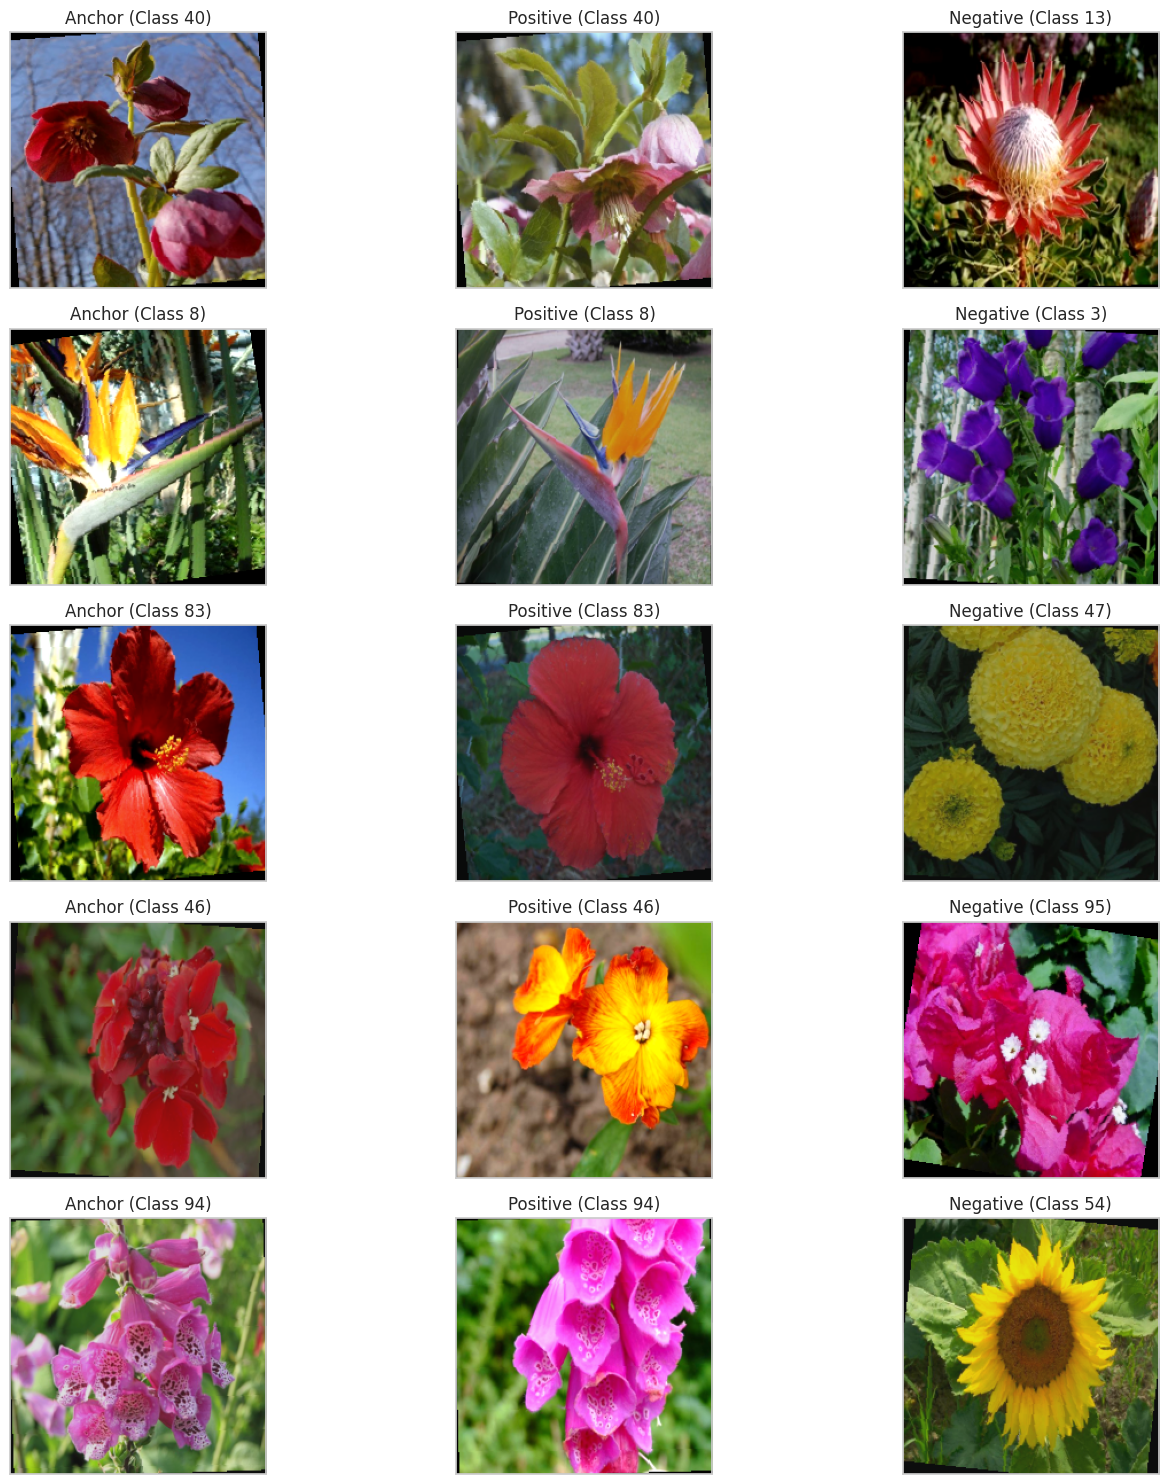

In [15]:
# Function to visualize sample triplets from the dataset
def visualize_triplets(dataloader, num_samples=5):
    """
    Visualize sample triplets from the dataloader with their class labels.

    Args:
        dataloader: DataLoader to sample from
        num_samples: Number of triplets to display
    """
    # Get a batch of samples
    (anchors, positives, negatives), (anchor_classes, pos_classes, neg_classes) = next(iter(dataloader))

    # Only show the first num_samples
    anchors = anchors[:num_samples]
    positives = positives[:num_samples]
    negatives = negatives[:num_samples]
    anchor_classes = anchor_classes[:num_samples]
    pos_classes = pos_classes[:num_samples]
    neg_classes = neg_classes[:num_samples]

    # Create a figure to display the triplets
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3*num_samples))

    # Inverse normalization function to convert tensors back to images
    inv_normalize = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])
    ])

    # Display each triplet
    for i in range(num_samples):
        # Convert tensors to images
        anchor_img = inv_normalize(anchors[i]).permute(1, 2, 0).cpu().numpy().clip(0, 1)
        pos_img = inv_normalize(positives[i]).permute(1, 2, 0).cpu().numpy().clip(0, 1)
        neg_img = inv_normalize(negatives[i]).permute(1, 2, 0).cpu().numpy().clip(0, 1)

        # Display images
        axes[i, 0].imshow(anchor_img)
        axes[i, 1].imshow(pos_img)
        axes[i, 2].imshow(neg_img)

        # Set titles
        axes[i, 0].set_title(f"Anchor (Class {anchor_classes[i]})")
        axes[i, 1].set_title(f"Positive (Class {pos_classes[i]})")
        axes[i, 2].set_title(f"Negative (Class {neg_classes[i]})")

        # Remove axis ticks
        for j in range(3):
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    plt.tight_layout()
    plt.show()

# Visualize some training triplets
print("Sample training triplets:")
visualize_triplets(train_loader, num_samples=5)

## Section 5: Triplet Network Architecture

Now we'll implement our Triplet network architecture. The network will consist of:
1. A backbone network (from timm) for feature extraction
2. An embedding layer for dimension reduction and feature learning

The architecture supports semi-hard triplet mining and will be trained using nn.TripletMarginLoss.

In [33]:
class TripletNetwork(nn.Module):
    """
    Triplet Network architecture for image similarity using triplet loss.
    The network shares weights across all three inputs (anchor, positive, negative).
    """
    def __init__(self, backbone_name='resnet18', pretrained=True, embedding_dim=128, training_mode='transfer_learning'):
        """
        Initialize the Triplet network.

        Args:
            backbone_name: Name of the backbone network from timm
            pretrained: Whether to use pretrained weights
            embedding_dim: Dimension of the embedding layer
            training_mode: One of 'full_training', 'fine_tuning', 'transfer_learning'
        """
        super(TripletNetwork, self).__init__()

        # Create backbone network from timm
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )

        # Get backbone output dimension
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            backbone_output_dim = self.backbone(dummy_input).shape[1]
        
        # Embedding layer to reduce dimensionality
        self.embedding = nn.Sequential(
            nn.Linear(backbone_output_dim, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU(inplace=True)
        )
        
        # Apply training mode settings
        self.training_mode = training_mode
        self._apply_training_mode()
        
    def _apply_training_mode(self):
        """Apply the selected training mode to the network"""
        if self.training_mode == 'transfer_learning':
            # Freeze the entire backbone
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("Transfer learning mode: backbone frozen, only training embedding layer")

        elif self.training_mode == 'fine_tuning':
            # Freeze early layers, train later layers
            # This is a common approach for fine-tuning
            layers_to_freeze = []

            # Handle different model architectures
            if hasattr(self.backbone, 'stem'):
                # Vision transformer style models often have a stem
                layers_to_freeze.append('stem')

            if hasattr(self.backbone, 'stages') and len(self.backbone.stages) > 2:
                # For models with stages (like RegNet, ConvNext, etc.)
                # Freeze early stages, keep later ones trainable
                early_stages = len(self.backbone.stages) // 2
                for i in range(early_stages):
                    layers_to_freeze.append(f'stages.{i}')

            elif hasattr(self.backbone, 'layer1'):
                # ResNet style models
                layers_to_freeze.extend(['conv1', 'bn1', 'act1', 'maxpool', 'layer1', 'layer2'])

            elif hasattr(self.backbone, 'blocks') and len(self.backbone.blocks) > 4:
                # Vision transformer style with blocks
                block_count = len(self.backbone.blocks)
                blocks_to_freeze = block_count // 2
                for i in range(blocks_to_freeze):
                    layers_to_freeze.append(f'blocks.{i}')

            # Apply freezing
            for name, param in self.backbone.named_parameters():
                param.requires_grad = True  # Default to trainable
                for layer_name in layers_to_freeze:
                    if layer_name in name:
                        param.requires_grad = False
                        break

            print(f"Fine-tuning mode: {len(layers_to_freeze)} early layers/blocks frozen, later layers trainable")

        else:  # full_training
            # Train the entire network
            for param in self.backbone.parameters():
                param.requires_grad = True
            print("Full training mode: all layers trainable")
    
    def forward_one(self, x):
        """Forward pass for a single image"""
        features = self.backbone(x)
        embeddings = self.embedding(features)
        # Normalize embeddings to have unit length
        embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings
        
    def forward(self, anchor, positive, negative):
        """
        Forward pass for triplet inputs.

        Args:
            anchor: Anchor image tensor [B, C, H, W]
            positive: Positive image tensor [B, C, H, W]
            negative: Negative image tensor [B, C, H, W]

        Returns:
            anchor_embedding: Embedding for anchor [B, embedding_dim]
            positive_embedding: Embedding for positive [B, embedding_dim]
            negative_embedding: Embedding for negative [B, embedding_dim]
        """
        anchor_embedding = self.forward_one(anchor)
        positive_embedding = self.forward_one(positive)
        negative_embedding = self.forward_one(negative)
        
        return anchor_embedding, positive_embedding, negative_embedding
    
    def get_embedding(self, x):
        """Get embeddings for a batch of images (for visualization)"""
        return self.forward_one(x)
        
    def compute_similarity(self, img1, img2):
        """
        Compute similarity between two images.

        Args:
            img1: First image tensor [B, C, H, W]
            img2: Second image tensor [B, C, H, W]

        Returns:
            similarity: Cosine similarity between the embeddings [B]
        """
        # Get embeddings
        with torch.no_grad():
            embed1 = self.forward_one(img1)
            embed2 = self.forward_one(img2)

            # Normalize embeddings
            embed1 = F.normalize(embed1, p=2, dim=1)
            embed2 = F.normalize(embed2, p=2, dim=1)
            
            # Compute cosine similarity (embeddings are already normalized)
            similarity = torch.sum(embed1 * embed2, dim=1)
            
            # Scale to [0, 1] range
            similarity = torch.sigmoid(similarity * 5)
            
        return similarity

In [39]:
# Initialize the Triplet network
model = TripletNetwork(
    backbone_name=CONFIG['backbone'],
    pretrained=True,
    embedding_dim=CONFIG['embedding_dim'],
    training_mode=CONFIG['training_mode']
)

# Move model to device
model = model.to(CONFIG['device'])

# Print model summary
print(f"Initialized Triplet network with {CONFIG['backbone']} backbone")
print(f"Feature embedding dimension: {CONFIG['embedding_dim']}")

Fine-tuning mode: 2 early layers/blocks frozen, later layers trainable
Initialized Triplet network with tiny_vit_5m_224.in1k backbone
Feature embedding dimension: 512


In [40]:
# Function to print model architecture and parameters
def print_model_summary(model):
    print("Parameters:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Percentage of trainable parameters: {100. * trainable_params / total_params:.2f}%")
    print("\nModel Architecture:")
    print(model)

# Print the summary of the initialized model
print_model_summary(model)

Parameters:
  Total parameters: 5,237,140
  Trainable parameters: 4,738,444
  Percentage of trainable parameters: 90.48%

Model Architecture:
TripletNetwork(
  (backbone): TinyVit(
    (patch_embed): PatchEmbed(
      (conv1): ConvNorm(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (act): GELU(approximate='none')
      (conv2): ConvNorm(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stages): Sequential(
      (0): ConvLayer(
        (blocks): Sequential(
          (0): MBConv(
            (conv1): ConvNorm(
              (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

## Section 6: Loss Functions, Optimizer, and Metrics

Next, we'll define our loss function, optimizer, and evaluation metrics for training and evaluating the Triplet network.

In [41]:
# Define triplet loss function
criterion = nn.TripletMarginLoss(margin=CONFIG['margin'], p=2)

# Define optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    verbose=True
)

# Function to compute accuracy for similarity prediction
def compute_accuracy(outputs, targets, threshold=0.5):
    """
    Compute accuracy for binary similarity prediction.
    
    Args:
        outputs: Similarity scores [N]
        targets: Binary labels (0: different, 1: same) [N]
        threshold: Similarity threshold
        
    Returns:
        accuracy: Binary classification accuracy
    """
    predictions = (outputs >= threshold).float()
    correct = (predictions == targets).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy

# Function to compute ROC-AUC for similarity prediction
def compute_roc_auc(outputs, targets):
    """
    Compute ROC-AUC for similarity prediction.
    
    Args:
        outputs: Similarity scores [N]
        targets: Binary labels (0: different, 1: same) [N]
        
    Returns:compute_accuracy
        roc_auc: Area under ROC curve
    """
    # Convert to numpy for sklearn
    outputs_np = outputs.cpu().detach().numpy()
    targets_np = targets.cpu().detach().numpy()
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(targets_np, outputs_np)
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

print(f"Initialized Triplet Margin Loss with margin={CONFIG['margin']}")
print(f"Initialized optimizer with lr={CONFIG['learning_rate']}")

Initialized Triplet Margin Loss with margin=1.0
Initialized optimizer with lr=0.0001


## Section 7: Training and Validation Functions

Now let's define functions for training and validating our Triplet network.

In [42]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    
    Args:
        model: The Triplet network
        dataloader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to use for training
        
    Returns:
        avg_loss: Average loss for the epoch
        triplet_accuracy: Percentage of triplets where d(a,p) < d(a,n)
    """
    model.train()
    running_loss = 0.0
    triplets_satisfied = 0
    total_triplets = 0
    
    # Progress bar
    pbar = tqdm(dataloader, desc="Training")
    
    for (anchors, positives, negatives), _ in pbar:
        # Move data to device
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        anchor_embeddings, positive_embeddings, negative_embeddings = model(anchors, positives, negatives)
        
        # Compute loss
        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * anchors.size(0)
        
        # Compute triplet accuracy (percentage of triplets where d(a,p) < d(a,n))
        with torch.no_grad():
            # Calculate distances
            ap_distances = torch.norm(anchor_embeddings - positive_embeddings, dim=1)
            an_distances = torch.norm(anchor_embeddings - negative_embeddings, dim=1)
            
            # Count triplets where d(a,p) < d(a,n)
            satisfied = (ap_distances < an_distances).sum().item()
            triplets_satisfied += satisfied
            total_triplets += anchors.size(0)
        
        # Update progress bar
        triplet_acc = satisfied / anchors.size(0)
        pbar.set_postfix(loss=loss.item(), triplet_acc=f"{triplet_acc:.4f}")
    
    # Compute epoch metrics
    avg_loss = running_loss / total_triplets
    triplet_accuracy = triplets_satisfied / total_triplets
    
    return avg_loss, triplet_accuracy

def validate(model, dataloader, threshold, device):
    """
    Validate the model on a validation set of pairs.
    
    Args:
        model: The Triplet network
        dataloader: DataLoader for validation pairs
        threshold: Similarity threshold
        device: Device to use for validation
        
    Returns:
        accuracy: Binary classification accuracy
        roc_auc: ROC-AUC score
        threshod: Best validation threshold
    """
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    
    # Initialize lists to store predictions and targets for ROC-AUC
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        # Progress bar
        pbar = tqdm(dataloader, desc="Validation")
        
        for (img1, img2), targets, _ in pbar:
            # Move data to device
            img1, img2, targets = img1.to(device), img2.to(device), targets.to(device)
            
            # Compute similarity
            outputs = model.compute_similarity(img1, img2)
            
            # Compute accuracy
            acc = compute_accuracy(outputs, targets, threshold)
            
            # Update running metrics
            running_acc += acc * img1.size(0)
            
            # Update progress bar
            pbar.set_postfix(acc=acc)
            
            # Store predictions and targets for ROC-AUC
            all_outputs.append(outputs)
            all_targets.append(targets)
    
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)

    best_thresh = None
    best_acc = 0

    outputs_np = all_outputs.cpu().detach().numpy().flatten()
    targets_np = all_targets.cpu().detach().numpy().flatten()
    
    for thresh in np.linspace(min(outputs_np), max(outputs_np), 100):
        predictions = (outputs_np >= thresh).astype(int)
        acc = (predictions == targets_np).mean()
    
        if acc > best_acc:
            best_acc = acc
            best_thresh = thresh

    threshold = best_thresh

    # Compute accuracy
    val_acc = compute_accuracy(all_outputs, all_targets.flatten(), threshold)
    
    # Compute ROC-AUC
    val_roc_auc = compute_roc_auc(all_outputs, all_targets)
    
    return val_acc, val_roc_auc, threshold

## Section 8: Model Training

Now let's train our Triplet network for the specified number of epochs.

In [43]:
# Initialize lists to store metrics
train_losses = []
triplet_accuracies = []
val_accs = []
val_roc_aucs = []

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
early_stop_counter = 0
min_delta = 0.001  # Minimum change to qualify as an improvement

# Best model tracking
best_val_acc = 0.0
best_val_roc_auc = 0.0
best_epoch = -1
threshold = 0.5

# Training loop
print(f"Starting training for {CONFIG['epochs']} epochs...")
for epoch in range(CONFIG['epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    
    # Re-generate triplets for each epoch
    train_dataset.create_triplets()
    
    # Train for one epoch
    train_loss, triplet_accuracy = train_epoch(
        model, train_loader, criterion, optimizer, CONFIG['device']
    )
    
    # Validate
    val_acc, val_roc_auc, threshold = validate(model, val_loader, threshold, CONFIG['device'])
    
    # Update learning rate scheduler
    scheduler.step(1 - val_acc)  # Use 1 - accuracy as "loss" for scheduling
    
    # Store metrics
    train_losses.append(train_loss)
    triplet_accuracies.append(triplet_accuracy)
    val_accs.append(val_acc)
    val_roc_aucs.append(val_roc_auc)
    
    # Print epoch summary
    print(f"Train Loss: {train_loss:.4f}, Triplet Accuracy: {triplet_accuracy:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}, Val Threshold: {threshold:.4f}")
    
    # Check if this is the best model so far
    if val_acc > best_val_acc - min_delta:
        best_val_acc = val_acc
        best_val_roc_auc = val_roc_auc
        best_epoch = epoch
        early_stop_counter = 0  # Reset counter
        
        # Save the best model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_acc': val_acc,
            'val_roc_auc': val_roc_auc,
            'threshold': threshold,
            'config': CONFIG
        }, os.path.join(CONFIG['model_dir'], 'best_model_triplet_loss.pth'))
        
        print(f"New best model saved! (Epoch {epoch+1})")
    else:
        early_stop_counter += 1
        print(f"No improvement in validation loss. Early stopping counter: {early_stop_counter}/{patience}")
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_acc': val_acc,
            'val_roc_auc': val_roc_auc,
            'threshold': threshold,
            'config': CONFIG
        }, os.path.join(CONFIG['model_dir'], f'checkpoint_triplet_epoch_{epoch+1}.pth'))
        
        print(f"Checkpoint saved at epoch {epoch+1}")

    # Check early stopping condition
    if early_stop_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs!")
        break

print("\nTraining complete!")
print(f"Best model at epoch {best_epoch+1}:")
print(f"Validation Accuracy: {best_val_acc:.4f}, ROC-AUC: {best_val_roc_auc:.4f}, Validation Threshold: {threshold:.4f}")

Starting training for 30 epochs...

Epoch 1/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.4257, Triplet Accuracy: 0.9140
Val Accuracy: 0.8838, Val ROC-AUC: 0.9404, Val Threshold: 0.9486
New best model saved! (Epoch 1)

Epoch 2/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.2433, Triplet Accuracy: 0.9577
Val Accuracy: 0.9039, Val ROC-AUC: 0.9520, Val Threshold: 0.9238
New best model saved! (Epoch 2)

Epoch 3/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.1841, Triplet Accuracy: 0.9688
Val Accuracy: 0.9191, Val ROC-AUC: 0.9624, Val Threshold: 0.9537
New best model saved! (Epoch 3)

Epoch 4/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.1643, Triplet Accuracy: 0.9756
Val Accuracy: 0.9137, Val ROC-AUC: 0.9611, Val Threshold: 0.9686
No improvement in validation loss. Early stopping counter: 1/5

Epoch 5/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.1403, Triplet Accuracy: 0.9836
Val Accuracy: 0.9137, Val ROC-AUC: 0.9586, Val Threshold: 0.8951
No improvement in validation loss. Early stopping counter: 2/5
Checkpoint saved at epoch 5

Epoch 6/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.1353, Triplet Accuracy: 0.9862
Val Accuracy: 0.9196, Val ROC-AUC: 0.9647, Val Threshold: 0.8440
New best model saved! (Epoch 6)

Epoch 7/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.1074, Triplet Accuracy: 0.9894
Val Accuracy: 0.9270, Val ROC-AUC: 0.9670, Val Threshold: 0.9390
New best model saved! (Epoch 7)

Epoch 8/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.1074, Triplet Accuracy: 0.9911
Val Accuracy: 0.9289, Val ROC-AUC: 0.9685, Val Threshold: 0.9237
New best model saved! (Epoch 8)

Epoch 9/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.0906, Triplet Accuracy: 0.9948
Val Accuracy: 0.9353, Val ROC-AUC: 0.9691, Val Threshold: 0.9587
New best model saved! (Epoch 9)

Epoch 10/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.0766, Triplet Accuracy: 0.9966
Val Accuracy: 0.9324, Val ROC-AUC: 0.9721, Val Threshold: 0.9062
No improvement in validation loss. Early stopping counter: 3/5
Checkpoint saved at epoch 10

Epoch 11/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.0728, Triplet Accuracy: 0.9956
Val Accuracy: 0.9392, Val ROC-AUC: 0.9714, Val Threshold: 0.9051
New best model saved! (Epoch 11)

Epoch 12/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.0722, Triplet Accuracy: 0.9940
Val Accuracy: 0.9319, Val ROC-AUC: 0.9690, Val Threshold: 0.8516
No improvement in validation loss. Early stopping counter: 4/5

Epoch 13/30


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.0635, Triplet Accuracy: 0.9963
Val Accuracy: 0.9338, Val ROC-AUC: 0.9661, Val Threshold: 0.9063
No improvement in validation loss. Early stopping counter: 5/5

Early stopping triggered after 13 epochs!

Training complete!
Best model at epoch 11:
Validation Accuracy: 0.9392, ROC-AUC: 0.9714, Validation Threshold: 0.9063


## Section 9: Visualize Training Metrics

Let's visualize the training progress to see how our model performed over time.

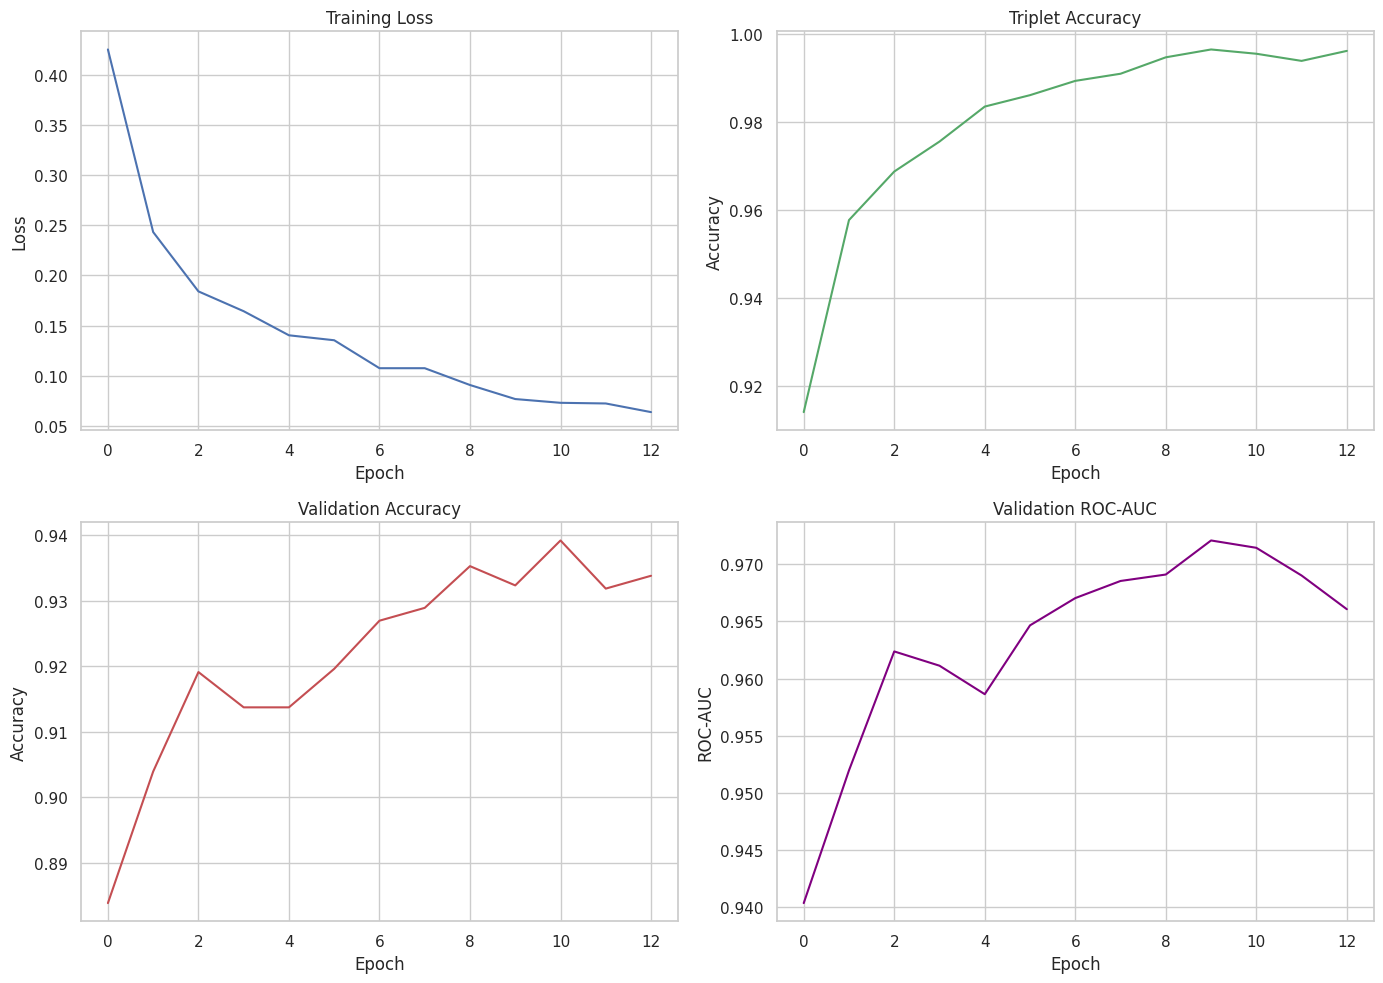

In [44]:
# Create figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot training loss
axs[0, 0].plot(train_losses, 'b-')
axs[0, 0].set_title('Training Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)

# Plot triplet accuracy
axs[0, 1].plot(triplet_accuracies, 'g-')
axs[0, 1].set_title('Triplet Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].grid(True)

# Plot validation accuracy
axs[1, 0].plot(val_accs, 'r-')
axs[1, 0].set_title('Validation Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].grid(True)

# Plot validation ROC-AUC
axs[1, 1].plot(val_roc_aucs, 'purple')
axs[1, 1].set_title('Validation ROC-AUC')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('ROC-AUC')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

## Section 10: Evaluate on Test Set

Now let's evaluate our trained model on the test set to assess its performance on unseen data.

Loaded best model from epoch 11


Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Test set performance:
Accuracy: 0.9338
ROC-AUC: 0.9682
Best Test Threshold: 0.9688


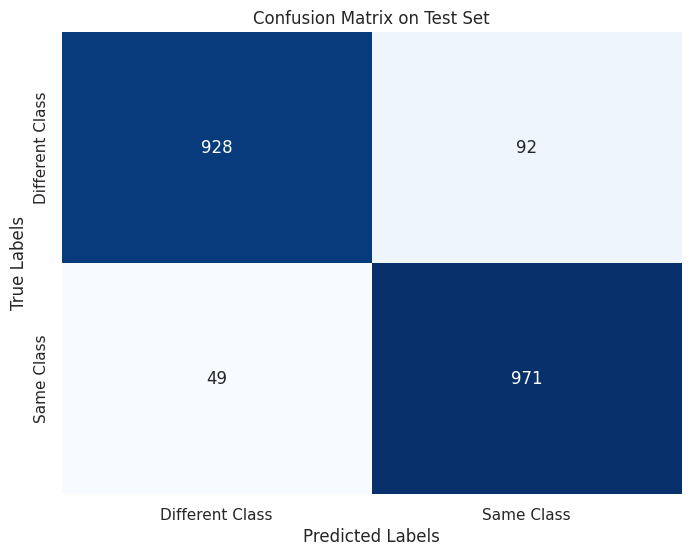


Classification Report:
                 precision    recall  f1-score   support

Different Class       0.95      0.91      0.93      1020
     Same Class       0.91      0.95      0.93      1020

       accuracy                           0.93      2040
      macro avg       0.93      0.93      0.93      2040
   weighted avg       0.93      0.93      0.93      2040



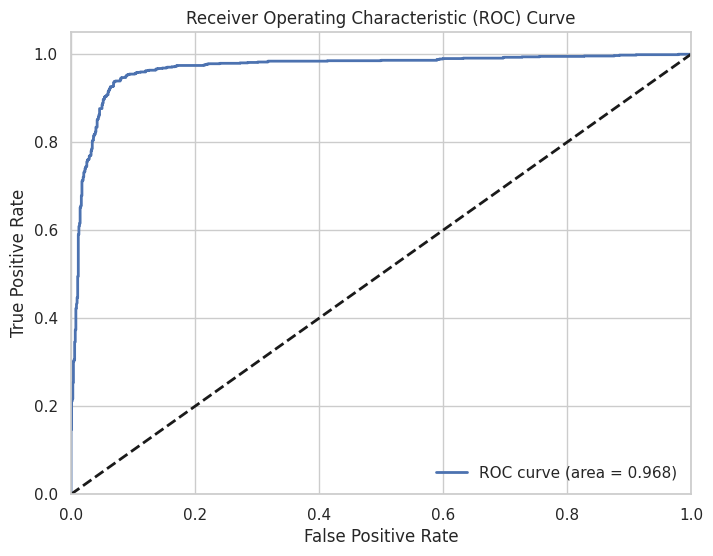

In [52]:
# Load the best model
checkpoint = torch.load(os.path.join(CONFIG['model_dir'], 'best_model_triplet_loss.pth'), weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Evaluate on test set
test_acc, test_roc_auc, threshold = validate(model, test_loader, checkpoint['threshold'], CONFIG['device'])

print(f"Test set performance:")
print(f"Accuracy: {test_acc:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")
print(f"Best Test Threshold: {threshold:.4f}")

# Get predictions and ground truth for plotting
model.eval()
all_outputs = []
all_targets = []

with torch.no_grad():
    for (img1, img2), targets, _ in test_loader:
        img1, img2 = img1.to(CONFIG['device']), img2.to(CONFIG['device'])
        outputs = model.compute_similarity(img1, img2)
        all_outputs.append(outputs.cpu())
        all_targets.append(targets)

all_outputs = torch.cat(all_outputs).numpy()
all_targets = torch.cat(all_targets).numpy()

test_preds = (all_outputs >= checkpoint['threshold'])

# ================
# Confusion Matrix
# ================
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

cm = confusion_matrix(all_targets, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.xticks([0.5, 1.5], ['Different Class', 'Same Class'])
plt.yticks([0.5, 1.5], ['Different Class', 'Same Class'])
plt.savefig(os.path.join(CONFIG['output_dir'], 'confusion_matrix.png'))
plt.show()

# =====================
# Classification Report
# =====================
print("\nClassification Report:")
print(classification_report(all_targets, test_preds, target_names=['Different Class', 'Same Class']))

# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_outputs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {test_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Section 11: Visualize Embeddings

Finally, let's visualize the learned embeddings from our Triplet network to see how well it separates different classes.

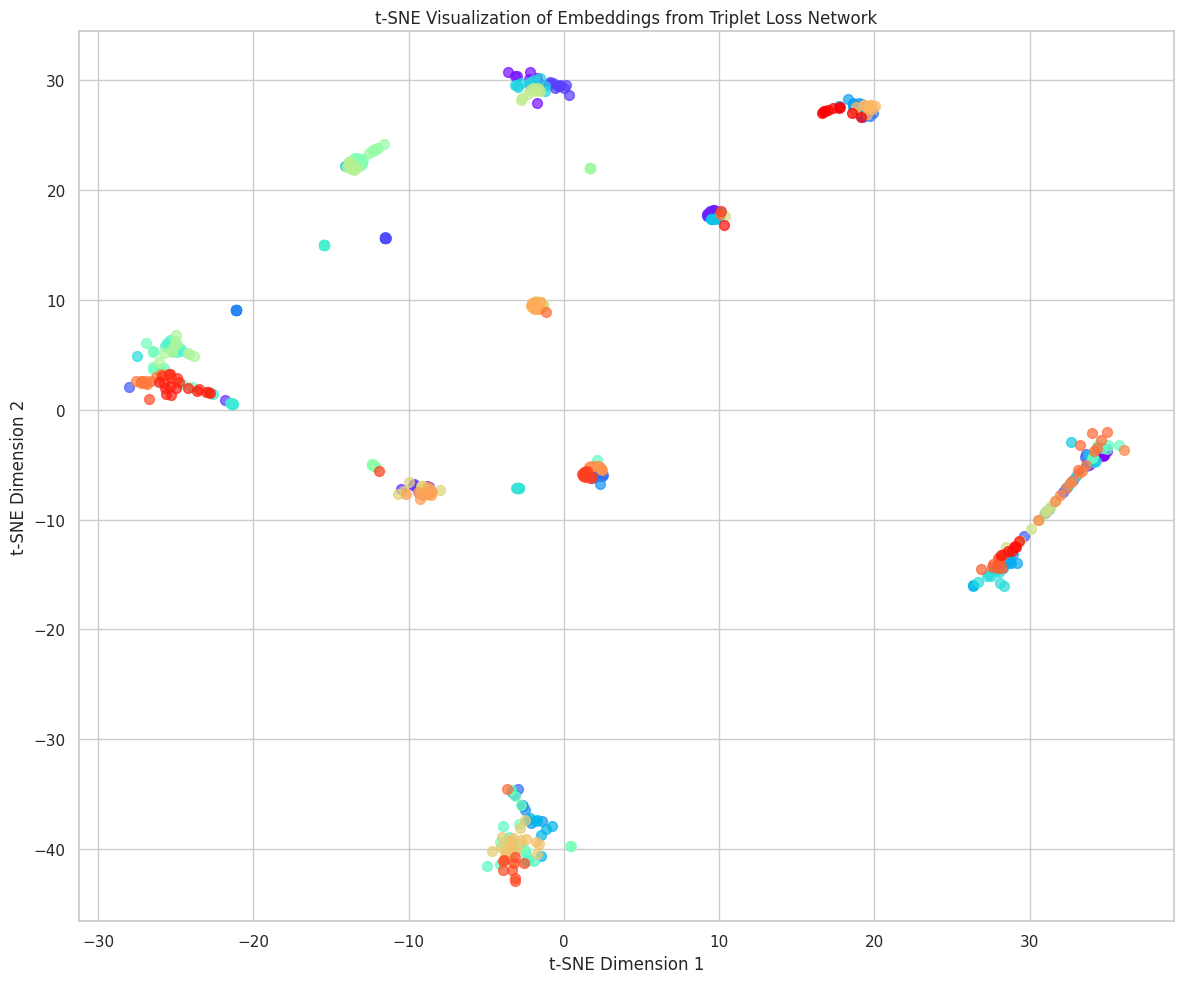

In [58]:
# Import TSNE for visualization
from sklearn.manifold import TSNE

# Function to get embeddings for a set of images
def get_embeddings(model, dataloader, device, max_samples=1000):
    """
    Get embeddings for a set of images.
    
    Args:
        model: The triplet network
        dataloader: DataLoader for images
        device: Device to use
        max_samples: Maximum number of samples to process
        
    Returns:
        embeddings: Tensor of embeddings
        labels: Corresponding labels
    """
    model.eval()
    all_embeddings = []
    all_labels = []
    sample_count = 0
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            # Move to device
            imgs = imgs.to(device)
            
            # Get embeddings
            embeddings = model.get_embedding(imgs)
            
            # Store embeddings and labels
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)
            
            # Update sample count
            sample_count += imgs.size(0)
            
            # Check if we've reached the maximum number of samples
            if sample_count >= max_samples:
                break
    
    # Concatenate embeddings and labels
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_embeddings, all_labels

# Create a dataset for test images (not pairs)
class SingleImageDataset(Dataset):
    def __init__(self, df, split='test', transform=None):
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.df.loc[idx, 'label']
        
        return image, label

# Create dataset and loader for visualization
test_single_dataset = SingleImageDataset(image_df, split='test', transform=val_transform)
test_single_loader = DataLoader(
    test_single_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# Get embeddings
embeddings, labels = get_embeddings(model, test_single_loader, CONFIG['device'], max_samples=500)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings.numpy())

# Plot embeddings
plt.figure(figsize=(12, 10))
unique_labels = np.unique(labels)

# Use a colormap with enough distinct colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    mask = labels == label
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[colors[i]],
        alpha=0.7,
        s=50
    )

plt.title('t-SNE Visualization of Embeddings from Triplet Loss Network')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.grid(True)
plt.show()

## Section 12: Conclusion

In this notebook, we've implemented a Triplet Network using nn.TripletMarginLoss for the flower similarity task. The key components of our implementation include:

1. A dynamic triplet generation strategy that creates triplets of (anchor, positive, negative) images
2. A modular Triplet network architecture with a backbone from timm
3. Training with nn.TripletMarginLoss to learn embeddings where similar items are closer and dissimilar items are farther apart
4. Evaluation of similarity performance using metrics like accuracy and ROC-AUC
5. Visualization of the learned embeddings to see how well the model separates different classes

The triplet loss approach provides an alternative to the Siamese network with contrastive loss and the center loss classification approach, potentially offering more robust embeddings for similarity tasks.